<IPython.core.display.Javascript object>


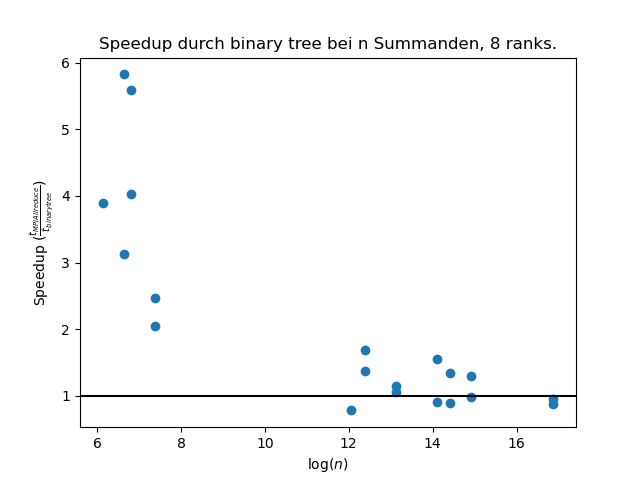

In [55]:
%matplotlib notebook
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

con = sqlite3.connect('file:results.db?mode=ro', uri=True)
cur = con.cursor()

# Calculate of average over runs of maximum of ranks
cur.execute("""
CREATE TEMPORARY VIEW avg_of_max_rank_time AS
	select n_summands, datafile, mode, AVG(time_us) as time_us from (
		select n_summands, datafile, mode, run, max(time_us) as time_us from results where cluster_size = 8 group by datafile, mode, run
	) group by datafile, mode;""")

# Self-join to match columns and divide tree / mpi
cur.execute("""
SELECT a.n_summands, a.datafile, a.time_us / b.time_us FROM avg_of_max_rank_time AS a, avg_of_max_rank_time AS b
WHERE a.datafile = b.datafile AND a.mode = 'mpi' AND b.mode = 'tree'
""")

data = cur.fetchall()
x = np.log(list(map(lambda x: x[0], data))) # n_summands
y = list(map(lambda x: x[2], data)) # time_us

f = plt.figure()

ax = f.subplots(1)
ax.set_title("Speedup durch binary tree bei n Summanden, 8 ranks.")
ax.axhline(1.0, color='black')
ax.set_ylabel('Speedup ($\\frac{t_{MPI Allreduce}}{t_{binary tree}}$)')
ax.set_xlabel('$\\log(n)$')
ax.scatter(x, y)
plt.show()
plt.savefig(fname="figure.svg")